In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os

### Load Data

In [2]:
X = pd.read_csv('../results/csvs/correct_hotspot_distances.csv')
y = pd.read_csv('../data/parking_Irvine_2023-01-01_2023-01-31.csv')
lot_ids = list(X['pk_lot'].unique())
y = y[y['pk_lot'].isin(lot_ids)]

# sort by timestamp
X['timestamp'] = pd.to_datetime(X['timestamp'])
y['dt_start_date'] = pd.to_datetime(y['dt_start_date'])
y['dt_start_date'] = y['dt_start_date'].dt.tz_convert('US/Pacific')
X = X.sort_values(by=['timestamp'])
y = y.sort_values(by=['dt_start_date'])
display(X.head(1))
display(y.head(1))

,timestamp,pk_lot,wasserstein,avg_hotspot_distance
0,2023-01-01 00:00:00-08:00,329825,0.744314,0.013144


,dt_start_date,dt_end_date,i_avail,i_occ,f_pct_occ,pk_lot_alias,f_occupancy_rank,pk_lot,location,geometry
15285,2023-01-01 00:14:03.331510-08:00,2023-01-01 12:14:03.331510+00:00,122,NaN,39.0,137a4355-016f-413d-aed7-a06532e25f7d,3.0,381380,POINT(-117.74155545543 33.6509462183159),"MULTIPOLYGON(((-117.741726902 33.650923943,-11..."


In [3]:

# why is everything after the second the same for dt_start_date and dt_end_date? something is wrong
# for now let's just aggregate by nearest hour
y.drop(columns=['dt_end_date', 'pk_lot_alias', 'f_occupancy_rank'], inplace=True)
y['timestamp'] = y['dt_start_date'].dt.round('h')
agg_dict = {'f_pct_occ': 'mean', 'i_avail': 'mean', 'i_occ': 'mean',
            'location': 'first', 'geometry': 'first',}
y = y.groupby(['timestamp', 'pk_lot']).agg(agg_dict).reset_index()
display(y.head())

,timestamp,pk_lot,f_pct_occ,i_avail,i_occ,location,geometry
0,2023-01-01 00:00:00-08:00,329825,22.0,186.0,NaN,POINT(-117.742706 33.6479646),"MULTIPOLYGON(((-117.74335 33.64835,-117.74201 ..."
1,2023-01-01 00:00:00-08:00,375750,8.0,205.0,NaN,POINT(-117.7398482 33.6484276),"MULTIPOLYGON(((-117.74027 33.64827,-117.74028 ..."
2,2023-01-01 00:00:00-08:00,380308,23.0,703.0,NaN,POINT(-117.744096689923 33.6488428962109),"MULTIPOLYGON(((-117.744053131 33.649582084,-11..."
3,2023-01-01 00:00:00-08:00,381380,39.0,122.0,NaN,POINT(-117.74155545543 33.6509462183159),"MULTIPOLYGON(((-117.741726902 33.650923943,-11..."
4,2023-01-01 00:00:00-08:00,381381,26.0,1623.0,NaN,POINT(-117.743547574184 33.6523127479216),"MULTIPOLYGON(((-117.743790442 33.653241372,-11..."


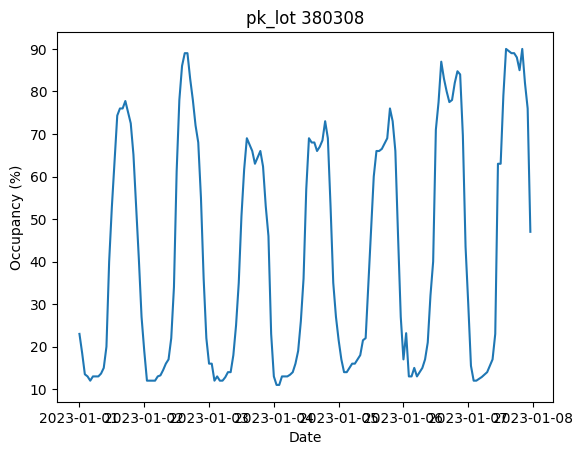

In [4]:
# plot f_pct_occ vs. timestamp for y for first week for random lot
lot_id = np.random.choice(lot_ids)
week_df = y[(y['timestamp'] < '2023-01-08') & (y['pk_lot'] == lot_id)]
plt.plot(week_df['timestamp'], week_df['f_pct_occ'])
plt.xlabel('Date')
plt.ylabel('Occupancy (%)')
plt.title(f'pk_lot {lot_id}')
plt.show()

In [5]:
print(X.shape)
print(y.shape)

# join X and y on timestamp and pk_lot
df = pd.merge(X, y, on=['timestamp', 'pk_lot'], how='inner')
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day

print(df.shape)
display(df.head(2))

(4464, 4)
(3564, 7)
(3564, 11)


,timestamp,pk_lot,wasserstein,avg_hotspot_distance,f_pct_occ,i_avail,i_occ,location,geometry,hour,day
0,2023-01-01 00:00:00-08:00,329825,0.744314,0.013144,22.0,186.0,NaN,POINT(-117.742706 33.6479646),"MULTIPOLYGON(((-117.74335 33.64835,-117.74201 ...",0,1
1,2023-01-01 00:00:00-08:00,375750,0.702161,0.016552,8.0,205.0,NaN,POINT(-117.7398482 33.6484276),"MULTIPOLYGON(((-117.74027 33.64827,-117.74028 ...",0,1


### Basic linear regression

In [6]:
# train a linear regression model using wasserstein and avg_hotspot_distance to predict f_pct_occ
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# input_features = ['wasserstein', 'avg_hotspot_distance', 'hour', 'day']
input_features = ['wasserstein', 'avg_hotspot_distance', 'day']

X = df[input_features].values
y = df['f_pct_occ'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LinearRegression()

# train model
model.fit(X_train, y_train)

# evaluate model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')


MSE: 583.2541691041156


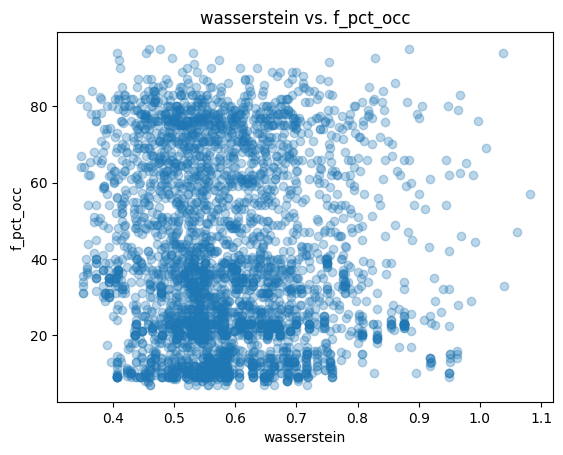

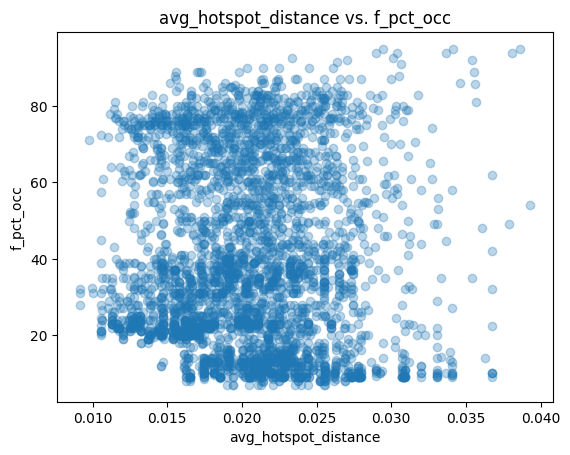

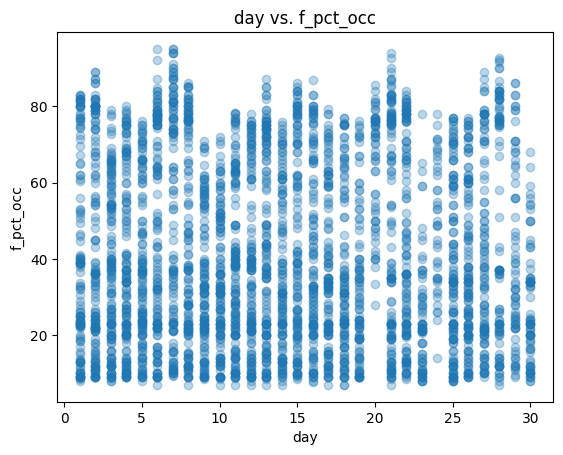

In [7]:
# plot each input feature vs. f_pct_occ
for feat in input_features:
    plt.scatter(df[feat], df['f_pct_occ'], alpha=0.3)
    plt.xlabel(feat)
    plt.ylabel('f_pct_occ')
    plt.title(f'{feat} vs. f_pct_occ')
    plt.show()

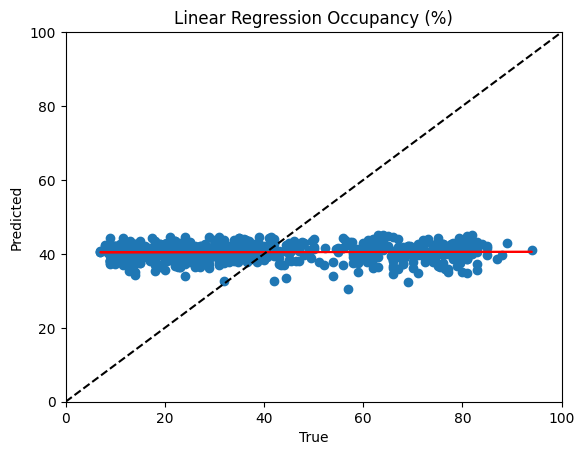

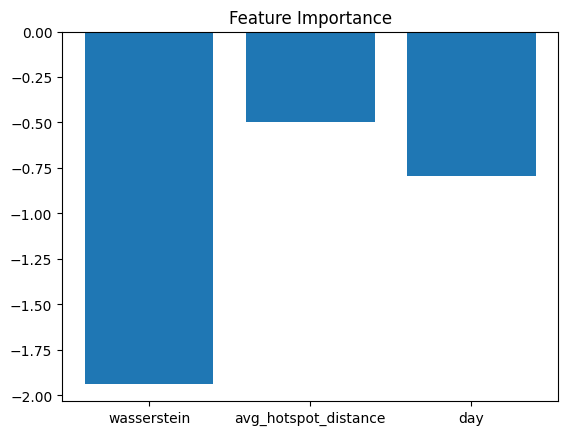

In [8]:
# plot predictions vs. true values
plt.scatter(y_test, y_pred)
# line of best fit
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m*y_test + b, color='red')
plt.plot([0, 100], [0, 100], color='black', linestyle='--')
plt.xlim(0, 100)
plt.ylim(0, 100)

plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Linear Regression Occupancy (%)')
plt.show()

# plot feature importance
importance = model.coef_
plt.bar([x for x in range(len(importance))], importance)
plt.xticks(ticks=[x for x in range(len(importance))], labels=input_features)
plt.title('Feature Importance')

plt.show()

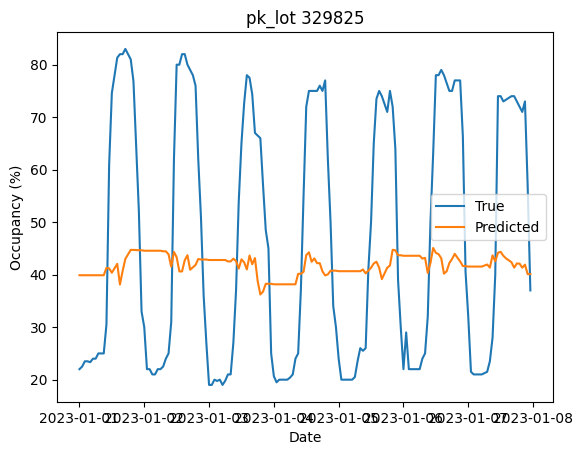

In [9]:
# plot the predicted time series
# get the first week of data for a random lot
lot_id = np.random.choice(lot_ids)
week_df = df[(df['timestamp'] < '2023-01-08') & (df['pk_lot'] == lot_id)]
X = week_df[input_features].values
X = scaler.transform(X)
y_pred = model.predict(X)

plt.plot(week_df['timestamp'], week_df['f_pct_occ'], label='True')
plt.plot(week_df['timestamp'], y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Occupancy (%)')
plt.title(f'pk_lot {lot_id}')
plt.legend()
plt.show()

### Train a machine learning model to predict the occupancy of a parking lot

At a given time, the model will use metrics about the distribution of trips at that time (call it $\^{X}$) compared to the aggregated distribution of trips over a larger time interval (call it $X$).

We use a shallow multi layered perceptron first with few inputs
- Wasserstein distance between $X$ and $\^{X}$
- Avg distance of cars to their nearest hotspot

In [10]:
# set directory to src
os.chdir('../src')

from model import Model

In [11]:
input_features = ['wasserstein', 'avg_hotspot_distance', 'hour', 'day']

X = df[input_features].values
y = df['f_pct_occ'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Model(input_dim=len(input_features))


AttributeError: 'Model' object has no attribute 'device'